# Ford GoBike System Data Exploration
### by Yi Le POH

## Preliminary Wrangling

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

### Loading in Dataset

In [2]:
# import modules required to download data
import requests
import os

In [3]:
# cell takes a considerable amount of time to run
# check if file exist
if not os.path.exists('fordgobike_tripdata.csv'):
    #download dataset using Request
    r = requests.get('https://s3.amazonaws.com/fordgobike-data/2017-fordgobike-tripdata.csv', stream=True)

    with open('fordgobike_tripdata.csv', 'wb') as fd:
        for line in r.raw:
            fd.write(line)
    fd.close()
    
    print('File succesfully downloaded')
else:
    print('File fordgobike_tripdata.csv already exist')

File fordgobike_tripdata.csv already exist


In [4]:
# load in downloaded dataset
df = pd.read_csv('fordgobike_tripdata.csv')

### Assessing Data
Looking for quality and tidiness issue in dataset

In [5]:
df.info()
# null entry detected

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519700 entries, 0 to 519699
Data columns (total 15 columns):
duration_sec               519700 non-null int64
start_time                 519700 non-null object
end_time                   519700 non-null object
start_station_id           519700 non-null int64
start_station_name         519700 non-null object
start_station_latitude     519700 non-null float64
start_station_longitude    519700 non-null float64
end_station_id             519700 non-null int64
end_station_name           519700 non-null object
end_station_latitude       519700 non-null float64
end_station_longitude      519700 non-null float64
bike_id                    519700 non-null int64
user_type                  519700 non-null object
member_birth_year          453159 non-null float64
member_gender              453238 non-null object
dtypes: float64(5), int64(4), object(6)
memory usage: 59.5+ MB


In [6]:
print(df.shape)
df.sample(5)

(519700, 15)


,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender
515603,1291,2017-07-03 16:31:51.8600,2017-07-03 16:53:23.3820,6,The Embarcadero at Sansome St,37.804770,-122.403234,37,2nd St at Folsom St,37.785000,-122.395936,252,Customer,NaN,NaN
132664,480,2017-11-14 20:08:30.2790,2017-11-14 20:16:30.6840,25,Howard St at 2nd St,37.787522,-122.397405,24,Spear St at Folsom St,37.789677,-122.390428,2910,Customer,1994.0,Male
419357,1189,2017-08-22 11:16:55.7270,2017-08-22 11:36:45.3090,19,Post St at Kearny St,37.788975,-122.403452,8,The Embarcadero at Vallejo St,37.799953,-122.398525,2678,Customer,NaN,NaN
263155,457,2017-10-09 07:16:30.3480,2017-10-09 07:24:07.7640,61,Howard St at 8th St,37.776513,-122.411306,19,Post St at Kearny St,37.788975,-122.403452,2076,Subscriber,1983.0,Male
450242,195,2017-08-10 14:26:03.5320,2017-08-10 14:29:19.0590,58,Market St at 10th St,37.776619,-122.417385,44,Civic Center/UN Plaza BART Station (Market St ...,37.781074,-122.411738,2626,Subscriber,1968.0,Male


Dataset has no tidiness issue. 
Only some minor quality issue, which includes:

- non-informative location coordinates
- datatype as object instead of datetime for start_time and end_time
- NaN in member_gender
- NaN in member_birth_year

Besides that, we will add some value by adding the region to the stations, as well as calculating the distance covered by the user using the coordinates.

### Data Cleaning

In [7]:
# make a copy of dataframe 
df_copy = df.copy()

#### Issue:
non-informative location coordinates

#### Define:
- determine the cut off coordinates (latitude, longitude) for different areas
- categorise the location of station using station coordinates
- define function that calculate across rows of data and return the location
- create 2 new columns to capture the location of the station (start, end)
- compare start and end station to verify that user use only within cities
- remove one of the location columns once done

#### Code:

In [8]:
# Ford GoBike operates at Bay Area, consisting of: San Francisco, East Bay and San Jose
# use prefix: SF, EB, SJ

# define a function to categorise the location of the station based on the coordinates of the station
def start_location_region(row):
    if row['start_station_longitude'] > -122:
        return 'SJ'
    elif row['start_station_longitude'] < -122:
        if row['start_station_latitude'] < 37.82:
            return 'SF'
        elif row['start_station_latitude'] > 37.82: 
            return 'EB'

In [9]:
def end_location_region(row):
    if row['end_station_longitude'] > -122:
        return 'SJ'
    elif row['end_station_longitude'] < -122:
        if row['end_station_latitude'] < 37.82:
            return 'SF'
        elif row['end_station_latitude'] > 37.82: 
            return 'EB'

In [10]:
df_copy['start_region'] = df_copy.apply(lambda row: start_location_region(row),
                                        axis=1)
df_copy['end_region'] = df_copy.apply(lambda row: end_location_region(row),
                                      axis=1)

In [11]:
df_test = df_copy[['start_region', 'end_region']]
(df_test['start_region'] == df_test['end_region']).any()

True

In [12]:
df_copy = df_copy.drop('end_region', axis=1)

rename_map = {'start_region':'region'}
df_copy = df_copy.rename(rename_map, axis=1)

#### Test:

In [13]:
df_copy.region.sample(5)

184083    SF
334729    SF
323135    EB
255660    SF
470967    SF
Name: region, dtype: object

#### Define:
- define a function to use the start and end coordinates to calculate distance (Harvesine calculation)
- return the distance (km) 
- capture the information in a new column, 'distance_km'

#### Code:

In [14]:
from math import sin, cos, sqrt, atan2, radians

def coordinate_distance(row):
    
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['start_station_latitude'])
    lon1 = radians(row['start_station_longitude'])
    lat2 = radians(row['end_station_latitude'])
    lon2 = radians(row['end_station_longitude'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [15]:
df_copy['distance_km'] = df_copy.apply(lambda row: coordinate_distance(row), axis=1)

#### Test:

In [16]:
df_copy.distance_km.sample(5)

353739    2.515542
256001    1.949519
178837    7.367770
215087    0.654227
77578     1.746622
Name: distance_km, dtype: float64

#### Issue:
- Incorrect datatype for variable
- NaN in dataset

#### Define:
- select start_time and use pandas to_datetime function to change datatype into datetime
- select end_time and use pandas to_datetime function to change datatype into datetime
- select rows that have non-null values in member_gender and member_birth_year
- reset index (if required)
- select member_birth_year change into datatype 'int64'
- create a dictionary for nominal variables to feed into a for loop later
- use pandas api to change datatype of nominal variables in a for loop

In [17]:
# changing the datatype of start_time and end_time to datetime
df_copy['start_time'] = pd.to_datetime(df_copy.start_time)
df_copy['end_time'] = pd.to_datetime(df_copy.end_time)

In [18]:
# remove NaN in member_gender and member_birth_year

cond1 = df_copy.member_gender.isnull()
df_copy = df_copy.loc[~cond1, :]

cond2 = df_copy.member_birth_year.isnull()
df_copy = df_copy.loc[~cond2, :]

df_copy.reset_index(inplace=True, drop = True)
# note potentially losing half of the data for user_type: Customer

In [19]:
# change birthyear datatype to int64
df_copy['member_birth_year'] = df_copy['member_birth_year'].astype('int64')

In [20]:
# convert region, gender and user type categorical types
nominal_var_dict = {'region': ['SF', 'EB', 'SJ'],
                    'user_type': ['Subscriber', 'Customer'],
                    'member_gender': ['Male', 'Female', 'Other']}

for var in nominal_var_dict:
    nominal_var = pd.api.types.CategoricalDtype(categories = nominal_var_dict[var])
    df_copy[var] = df_copy[var].astype(nominal_var)

#### Test:

In [66]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438087 entries, 0 to 438086
Data columns (total 24 columns):
duration_sec               438087 non-null int64
start_time                 438087 non-null datetime64[ns]
end_time                   438087 non-null datetime64[ns]
start_station_id           438087 non-null int64
start_station_name         438087 non-null object
start_station_latitude     438087 non-null float64
start_station_longitude    438087 non-null float64
end_station_id             438087 non-null int64
end_station_name           438087 non-null object
end_station_latitude       438087 non-null float64
end_station_longitude      438087 non-null float64
bike_id                    438087 non-null int64
user_type                  438087 non-null category
member_birth_year          438087 non-null int64
member_gender              438087 non-null category
region                     438087 non-null category
distance_km                438087 non-null float64
week             

### Structure of dataset

There are 519,700 entries in the dataset. Each entry has 15 features. The features are as below:
- duration
- start time
- end time
- start station location (latitude, longitude, name, id)
- end station location (latitude, longitude, name, id)
- bike id
- user type
- member birth year
- member gender

We have derived additional variables from the existing features. The derived features are as below:
- region
- distance

Most of the entries are categorial in nature.

The numeric features are: duration, distance, birth year and time.

### Main feature(s) of interest in dataset

In this project, we assuming the role of a data analyst who is part of a marketing team in Ford GoBike. 

Our primary objective is to better understand the demographics and the behaviour of our users. With these insights, we can design advertising campaigns accordingly, capturing more new users and retaining existing subscribers.

### Features in the dataset that supports investigation into feature(s) of interest

We will look into different user behaviour at different locations for different demographics. 

1. User behaviour features: usage duration, usage distance, time of use 
2. Location features: region, station location
3. Demographic features: user type, member birth year, member gender

We expect that the traffic will be highest at certain popular stations (highest density) and at peak hours (before and after work). 

We expect our user demographic to be on the younger side of the spectrum, and male could be slightly higher than female. 

We expect the duration and distance user by our user to be short, as we expect them to use this mode of transport as the "last-mile transportation". Meaning they will use GoBike as a mode of transport to cover the last portion of the distance to their destination.

## Univariate Exploration
We start by looking at the distribution of our first variable of interest: **duration_sec**, which is part of user behaviour

In [22]:
# checking some statistics to estiamte the parameters used in generating plots
df_copy.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year,distance_km
count,453159.000000,453159.000000,453159.000000,453159.000000,453159.000000,453159.000000,453159.000000,453159.000000,453159.000000,453159.000000
mean,832.934014,95.046132,37.771968,-122.364093,91.854907,37.772090,-122.363274,1680.628285,1980.404787,1.599837
std,2525.280717,84.578497,0.084914,0.104240,83.053529,0.084811,0.103723,972.828314,10.513488,0.983844
min,61.000000,3.000000,37.317298,-122.444293,3.000000,37.317298,-122.444293,10.000000,1886.000000,0.000000
25%,364.000000,25.000000,37.773492,-122.411726,24.000000,37.773793,-122.409851,795.000000,1974.000000,0.920679
50%,556.000000,67.000000,37.782411,-122.398525,66.000000,37.782411,-122.397405,1739.000000,1983.000000,1.408404
75%,838.000000,138.000000,37.795392,-122.391034,134.000000,37.795392,-122.391034,2530.000000,1988.000000,2.073144
max,86252.000000,340.000000,37.880222,-121.874119,340.000000,37.880222,-121.874119,3733.000000,1999.000000,62.313237


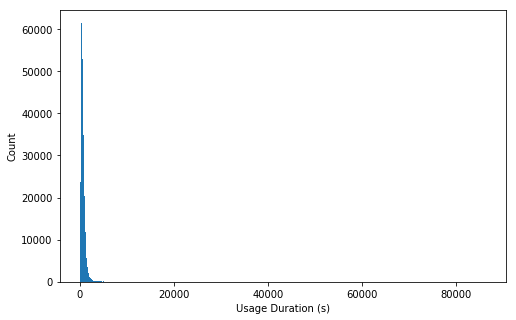

In [23]:
# standard-scaled distribution plot of duration of use
binsize = 100
bins = np.arange(0, df_copy['duration_sec'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df_copy, x = 'duration_sec', bins = bins)
plt.xlabel('Usage Duration (s)')
plt.ylabel('Count')
plt.show()

There seems to be outliers in terms of the duration. We will focus our plot on the duration below 5,000 sec.

The maximum duration observed is around 80,000 seconds which is around 22 hours. This indicates that there are users that uses GoBike for the whole day. In this project, we will exclude them as we will focus more on the majority of the users.

In [24]:
# selecting durations below 5000 seconds (~1.4 hours)
df_copy = df_copy[df_copy.duration_sec < 5000]

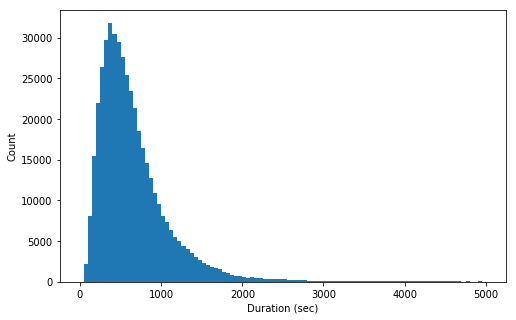

In [25]:
# standard-scaled distribution plot of duration of use
binsize = 50
bins = np.arange(0, df_copy['duration_sec'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df_copy, x = 'duration_sec', bins = bins)
plt.xlabel('Duration (sec)')
plt.ylabel('Count')
plt.show()

The distribution is highly skewed to the right. We will use a log scale in the x-axis to better check the modality of the distribution.

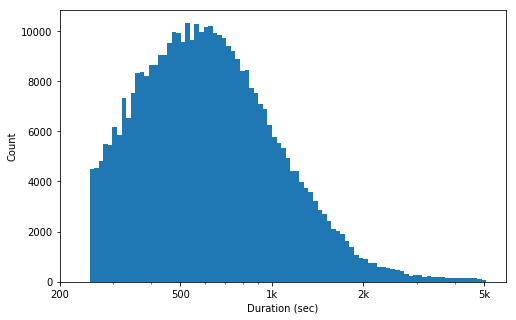

In [26]:
# there's a long tail in the distribution, so let's put it on a log scale
log_binsize = 0.015
bins = 10 ** np.arange(2.4, np.log10(df_copy['duration_sec'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df_copy, x = 'duration_sec', bins = bins)
plt.xscale('log')

tick_loc = [200, 500, 1e3, 2e3, 5e3]
tick_label = [200, 500, '1k', '2k', '5k']
plt.xticks(tick_loc, tick_label)

plt.xlabel('Duration (sec)')
plt.ylabel('Count')
plt.show()

Usage duration of GoBike has a unimodal distribution, where the mode lies in between 600-700 seconds. That is roughly 10 minutes. The distribution has a long tail to the right, number of users that uses GoBike drops sharply above the 2000 seconds mark.

Lets look at the distribution of our second variable of interest linked to user bahaviour: **distance_km**

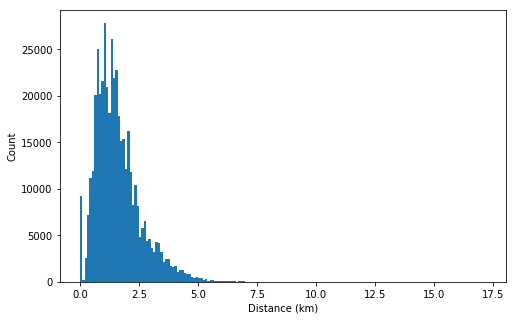

In [27]:
# standard-scaled distribution plot of distance covered
binsize = 0.1
bins = np.arange(0, df_copy['distance_km'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df_copy, x = 'distance_km', bins = bins)
plt.xlabel('Distance (km)')
plt.ylabel('Count')
plt.show()

Outlier exist on the right side of the plot. We will focus our plot for distances below 7 km

In [28]:
# selecting distances below 7 km
df_copy = df_copy[df_copy.distance_km < 7]

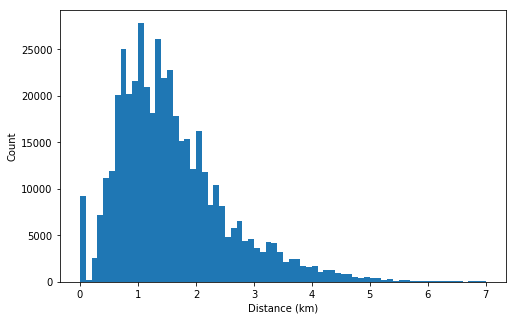

In [29]:
# standard-scaled distribution plot of distance covered
binsize = 0.1
bins = np.arange(0, df_copy['distance_km'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df_copy, x = 'distance_km', bins = bins)
plt.xlabel('Distance (km)')
plt.ylabel('Count')
plt.show()

The distribution of distrance travelled is skewed to the right. Distribution has a mode around 1 km. After the 2 km mark, the number of user that exceeds this distance drops rapidly.

Unusually high amount of 0 distance travelled, seen from the distribution plot of distance travelled.
This is interesting as it shows that there are a group of users who returns the bike to the original location where they undock the bike.

We will select data with distance greater than 0. As we effectively could not derive any useful information from the users who docked their bike back to the original position.

In [30]:
# selecting distances above 0 km, for later analysis
df_copy = df_copy[df_copy.distance_km > 0]

Lets look at the distribution of our third variable of interest: **time**

For time, we will use the 'start_time' variable. 

`sb.countplot(df_copy.start_time);` will not be able to show the plot we want to see. Hence, we have to categorise the time into their respective day of the month, day of the week and hour.

Since the mode time of usage is 10 minutes, we could effectively use the number of rides in a an hour as GoBike's 'usage traffic'.

In [31]:
# labeling the data using datetime functions
df_copy['week'] = df_copy.start_time.dt.week
df_copy['month'] = df_copy.start_time.dt.month

df_copy['month_day'] = df_copy.start_time.dt.day
df_copy['week_day'] = df_copy.start_time.dt.weekday
df_copy['hour'] = df_copy.start_time.dt.hour

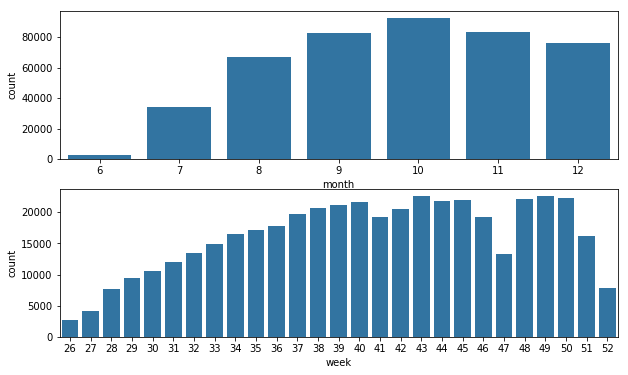

In [32]:
# countplot of the month and week 
fig, ax = plt.subplots(nrows=2, figsize = [10, 6])

base_color = sb.color_palette()[0]

sb.countplot(data = df_copy, x = 'month', color = base_color, ax = ax[0])
sb.countplot(data = df_copy, x = 'week', color = base_color, ax = ax[1])

plt.show()
# incomplete data for the whole year

From the countplot for the week and month, we see that the data for 2017 is only available after June, instead of the whole year (A followup analysis can be done with the 2018 data, if time permits). 

For this project, we will focus on unravelling the usage trends in: days in month, days in week and the time of the day

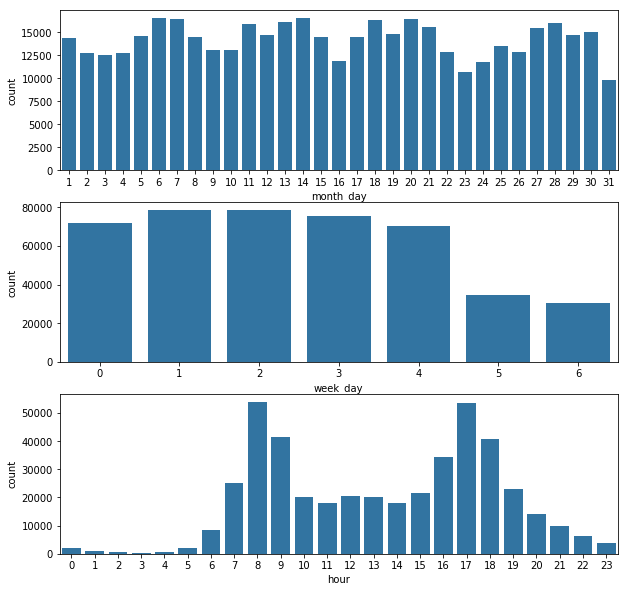

In [33]:
# countplot on days in month, days in week and time within a day
fig, ax = plt.subplots(nrows=3, figsize = [10, 10])

base_color = sb.color_palette()[0]

sb.countplot(data = df_copy, x = 'month_day', color = base_color, ax = ax[0])
sb.countplot(data = df_copy, x = 'week_day', color = base_color, ax = ax[1])
#tick_loc = [0, 1, 2, 3, 4, 5, 6]
#tick_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sb.countplot(data = df_copy, x = 'hour', color = base_color, ax = ax[2])

plt.show()

Looking at the usage trend against time, we can see that the usage throughout the month is fairly constant, with a cyclic trend of going up and down every 7 days or so.

If we look at the trend in days in week, this gives us greater clarity in the cyclic behaviour of the trend. We can see that the number of user that uses GoBike on the weekend is approximately 50% of that in weekday. Users tend to use GoBike more during the weekdays.

In a day, the usage of GoBike is the highest during the peak hours, betweem 8am - 9am and between 5pm - 6pm. Users tend to use GoBike before and after working hours to commute.

Let us look at the location variable: **region**

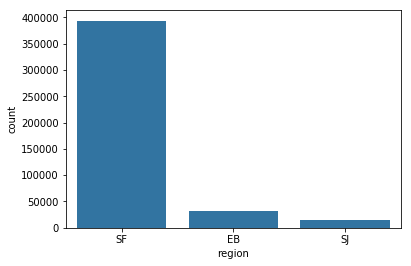

In [34]:
# countplot of region
base_color = sb.color_palette()[0]

sb.countplot(df_copy.region, color=base_color)
plt.show()

Highest number of users in San Francisco (~80%). Followed by East Bay (~10%) and San Jose (~10%)

We now look at the demographics of our user: **user_type, member_gender, gender_birth_year**

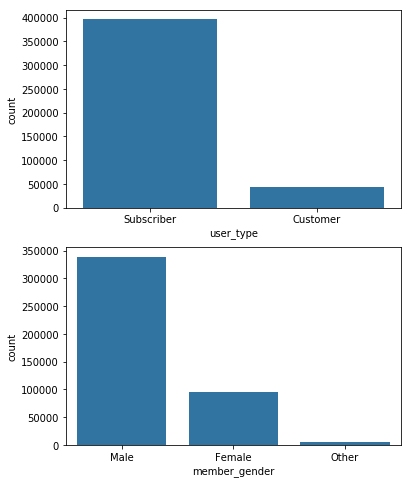

In [35]:
# countplot on user_type and member_gender
fig, ax = plt.subplots(nrows=2, figsize = [6, 8])

base_color = sb.color_palette()[0]

sb.countplot(data = df_copy, x = 'user_type', color = base_color, ax = ax[0])
sb.countplot(data = df_copy, x = 'member_gender', color = base_color, ax = ax[1])

plt.show()

A simple count plot shows that majority of the data captured are from the subscribers.

There are also more males than female users, where there is approximately 75% male users.

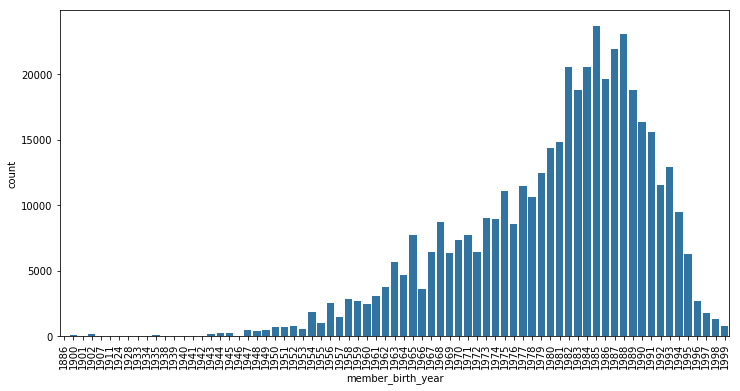

In [36]:
# count plot of member_birth_year
plt.figure(figsize=[12,6])

sb.countplot(data = df_copy, x = 'member_birth_year', color = base_color)
plt.xticks(rotation=90)

plt.show()

From the distribution, we can see that there are outliers in the far left. We will focus on plotting from 1960 onwards. 

Besides that, we will also make some changes in how the numbers are being displayed. Rather than showing the birth year, we will compute the members age. We will also focus on the age below 70.

In [37]:
# computing the member_age
df_copy['member_age'] = 2017 - df_copy.member_birth_year 

In [38]:
# selecting member_age below 70
df_copy = df_copy[df_copy.member_age <= 70]

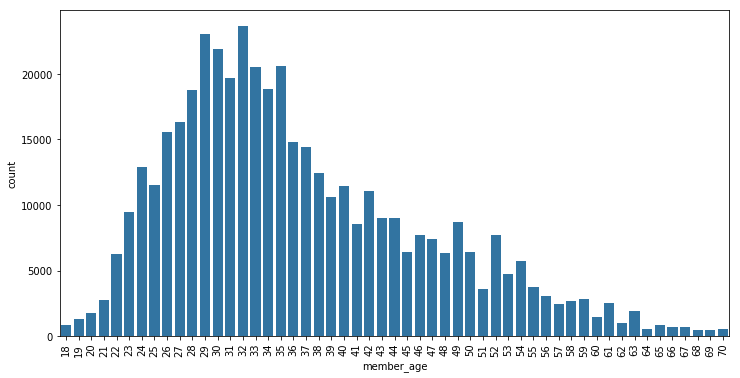

In [39]:
# count plot of member_birth_year
plt.figure(figsize=[12,6])

sb.countplot(data = df_copy, x = 'member_age', color = base_color)
plt.xticks(rotation=90)

plt.show()

From the member's age distribution above, we can see that the majority of the users are in between the age of 25 - 35.

In [40]:
# changing variables datatype to the correct datatype
df_copy.month_day = df_copy.month_day.astype('category')
df_copy.week_day = df_copy.week_day.astype('category')
df_copy.hour = df_copy.hour.astype('category')

In [41]:
# reset index after selecting and slicing the data to reduce errors later on
df_copy.reset_index(drop=True, inplace=True)

### Discussion on outliers in variable(s) of interest.
The variables: duration, distance and age have some outliers. In order to allow the plots to show the trends clearly, we have removed them from our dataset. The outliers could be caused by incorrect data entry.

The duration variable has a large range, we plot it on a log scale to examine it. Under the log transformation, we observed a unimodal distribution.

### Operations on the data to tidy, adjust, or change the form of the data. 
The time variable has been categorised into day of the month, day of the week and hour of the day. This is done such that aggregating the data and plotting them on a barchart is possible.

Age has been computed from birth year to allow easier comprehension.

## Bivariate Exploration
We will start by looking at the correlation between variables.

In [42]:
# listing out the numeric, categorical and time variable
numeric_vars = ['duration_sec', 'distance_km', 'member_age']
categoric_vars = ['user_type', 'member_gender', 'region'] 
time_vars = ['month_day', 'week_day', 'hour']

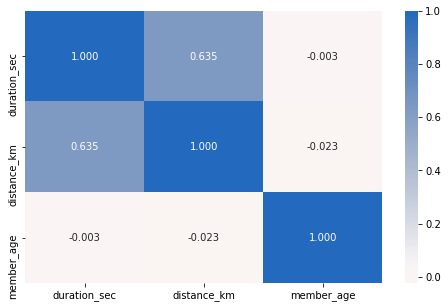

In [43]:
# correlation plot between the numeric variable
plt.figure(figsize = [8, 5])

sb.heatmap(df_copy[numeric_vars].corr(), annot = True, 
           fmt = '.3f', cmap = 'vlag_r', center = 0)
plt.show()

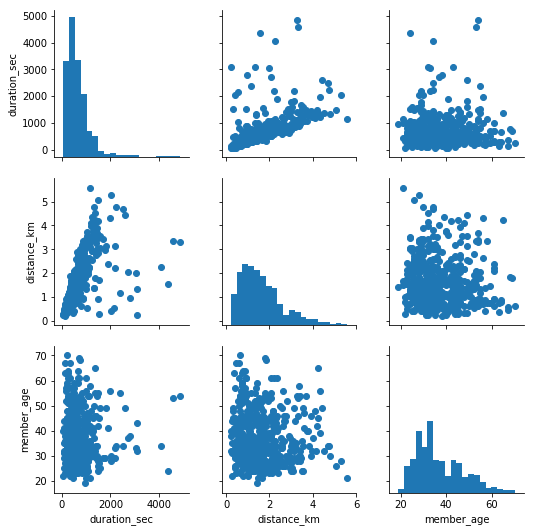

In [44]:
# a sample size of 500 is chosen such that the image rendered can be seen
samples = np.random.choice(df_copy.shape[0], 500, replace = False)
df_samp = df_copy.loc[samples,:]

# plot matrix between numeric variables
g = sb.PairGrid(data = df_samp, vars = numeric_vars)
# plot histogram for the diagonal matrices
g = g.map_diag(plt.hist, bins = 20);
# plot scatter plot for off diagonal matrices
g.map_offdiag(plt.scatter)

plt.show()

From the two bivariate plots above, we can see relationships between the numeric variables.

Overall, there seems to be no obvious relationship between the member's age and the GoBike usage in terms of distance and duration. This is reflected in both the correlation plot and the scatter plot.

Since there is relationship between usage distance and duration, let us focus on this 2 variables and construct a scatter plot.

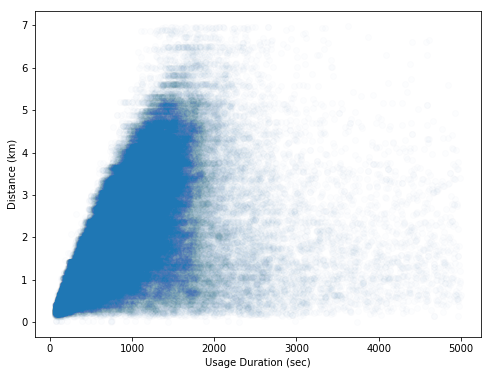

In [45]:
# scatter plot of duration against distance

plt.figure(figsize = [8, 6])
plt.scatter(data = df_copy, x = 'duration_sec', y = 'distance_km', alpha = 1/75)
plt.xlabel('Usage Duration (sec)')
plt.ylabel('Distance (km)')
plt.show()

There is a positive correlation between usage distance and duration. This is expected, as logically, the users are able to travel further given a longer duration. However, the duration seemed to be below 2,000 sec, approximately 30 mins. for most of the users. This could indicate that for journey that are expected to by above 30 mins, customers are less likely to use GoBike as the mode of transport. 

Diving deeper into the plot, we see that usage duration does not affect the minimum distance travel as much as the maximum distance travelled. From the plot, we can calculate the average distance travelled by users over a period of time.

A rough estimates shows that users are able to travel 4.2 km in 1,000 sec. That is approximately 15 km/hr, a reasonable speed cycling speed.

<Figure size 720x720 with 0 Axes>

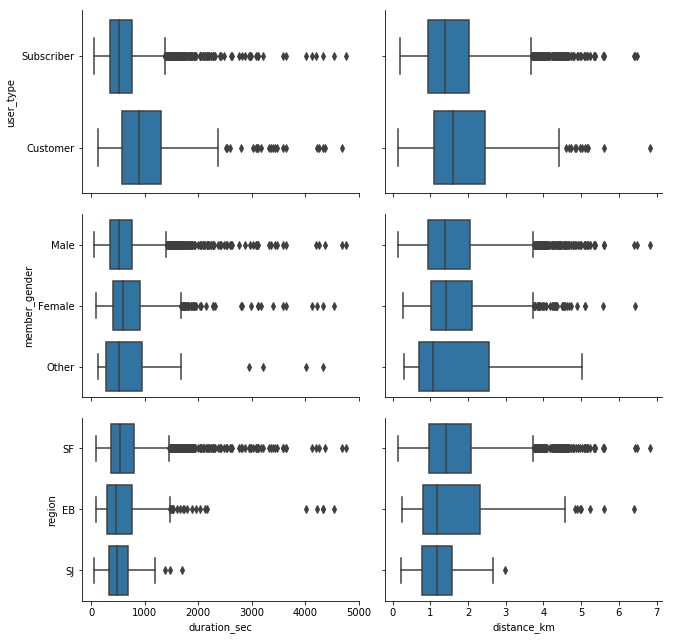

In [46]:
# plot matrix of numeric features against categorical features.

# sample size of 5000, for faster and better rendering
samples = np.random.choice(df_copy.shape[0], 5000, replace = False)
df_samp = df_copy.loc[samples,:]

# defining function to be used in Seaborn PairGrid function
def boxgrid(x, y, **kwargs):
    """ Function to create box plots """
    default_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = default_color)

# box plot of numeric and categorical features
plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = df_samp, x_vars = ['duration_sec', 'distance_km'], y_vars = categoric_vars,
                height = 3, aspect = 1.5)
g.map(boxgrid)
plt.show()

/Users/yilepoh/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 720x720 with 0 Axes>

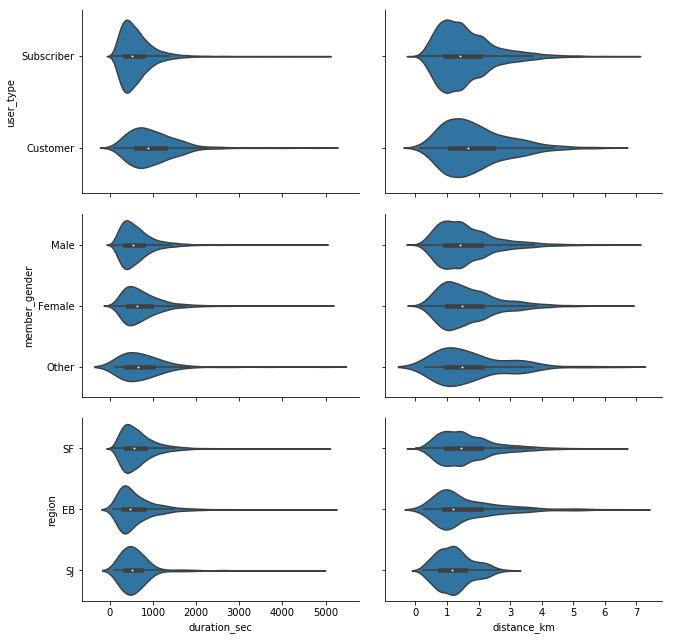

In [47]:
# reuse code to plot violin plot instead of box plot

samples = np.random.choice(df_copy.shape[0], 10000, replace = False)
df_samp = df_copy.loc[samples,:]

# function changed to plot violin plot
def violingrid(x, y, **kwargs):
    """ Function to create violin plots """
    default_color = sb.color_palette()[0]
    sb.violinplot(x, y, color = default_color)

plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = df_samp, x_vars = ['duration_sec', 'distance_km'], y_vars = categoric_vars,
                height = 3, aspect = 1.5)
g.map(violingrid)
plt.show()

From the box plot and violin plot, we can see the distribution of the usage duration and distance, across different categorical variables.

Overall, the usage duration of subscribers are shorter than customers. This is within expectation as those who have subscribed will most likely use GoBike as part of their daily commute as compared to the customers who uses GoBike on a per-ride-basis. Interestingly, the customer's per-ride duration limit is 30 min (1,800 sec), this is reflected in the sharp fall in distribution after 1,800 sec.

Another interesting trend observed in the plot matrix is, the range of distance for different region are different. San Jose region has a shorter distance as compared to East Bay and San Francisco. Upon further examination, we found that there are relatively fewer bike docking stations in San Jose as compared to other regions, and the stations are closer to each other. This explains the lower usage distance by the users.

There are no visible difference in the usage (duration and distance) between users of different gender.

<Figure size 720x720 with 0 Axes>

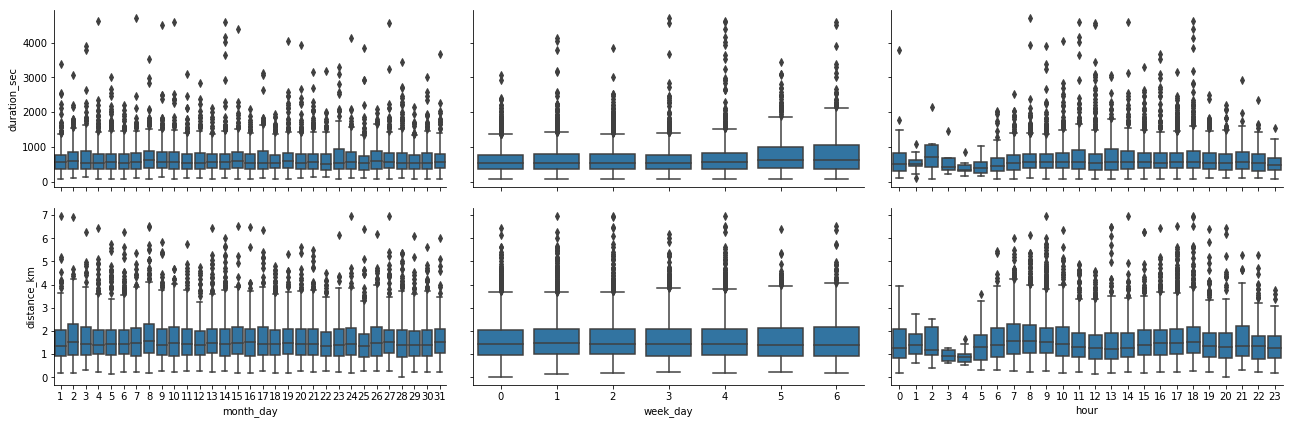

In [48]:
# reuse code to plot time variable instead of categorical variable

samples = np.random.choice(df_copy.shape[0], 10000, replace = False)
df_samp = df_copy.loc[samples,:]

# plot matrix using box plot
plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = df_samp, y_vars = ['duration_sec', 'distance_km'], x_vars = time_vars,
                height = 3, aspect = 2)
g.map(boxgrid)
plt.show()

Looking at the box grid of numeric variables against the time variables, we observed that there are no obvious difference in general.

One interesting observation is from the box plot of usage duration across the days of the week. We observed that the usage duration is greater in Saturday (day 5) and Sunday (day 6). We suspect that the customers are more likely to use GoBike in the weekends. Hence we will explore on that.

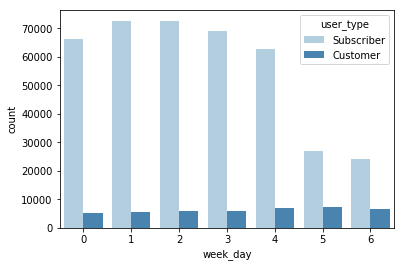

In [49]:
# countplot of different users in different days in the week
sb.countplot(data = df_copy, x = 'week_day', hue = 'user_type', palette = 'Blues')
plt.show()

From the countplot, we find that subsriber usage drops substantially, approximately 50%, leading to the observation above.

From the exploration plots above, user behaviour seemed to be fairly constant across member_gender and region. Let us look at the number of usages for different user_type at different months and hours in the day.

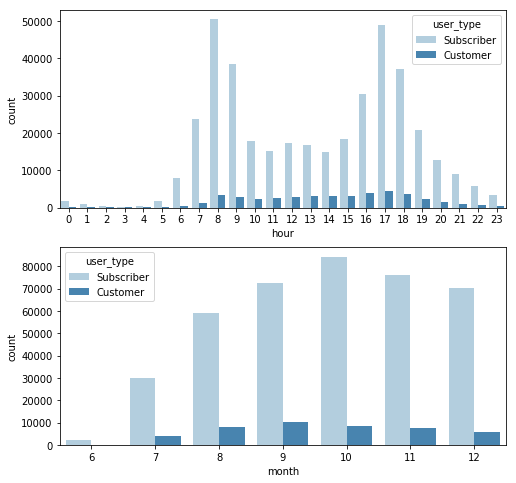

In [50]:
plt.figure(figsize = [8, 8])

# subplot 1:
plt.subplot(2, 1, 1)
sb.countplot(data = df_copy, x = 'hour', hue = 'user_type', palette = 'Blues')

# subplot 2:
ax = plt.subplot(2, 1, 2)
sb.countplot(data = df_copy, x = 'month', hue = 'user_type', palette = 'Blues')

plt.show()

The number of customers throughout the day is fairly constant. The fluctuations in terms of number of usages is less in customers as compared to subscribers.

The number of subscribers and customer follows the same trend over the year. The number of usages peaks around October and decreases as December approaches. Winter starts in December for the Bay Area. This could signify that GoBike usages is affected by the weather and season. 

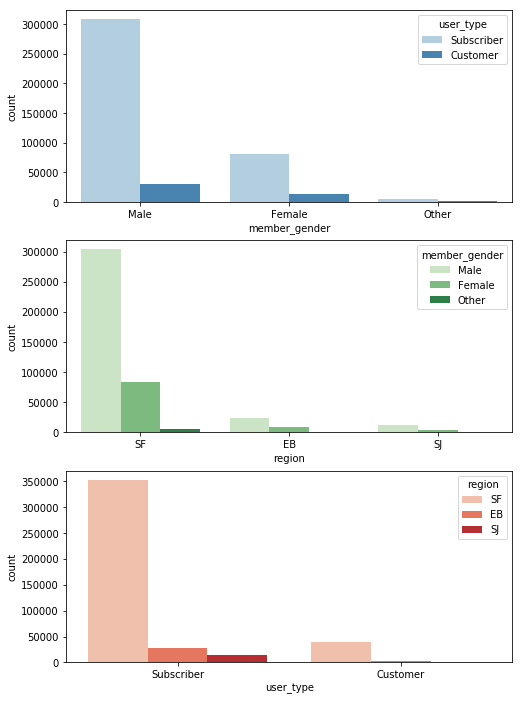

In [51]:
plt.figure(figsize = [8, 12])

# subplot 4:
ax = plt.subplot(3, 1, 1)
sb.countplot(data = df_copy, x = 'member_gender', hue = 'user_type', palette = 'Blues')

# subplot 5:
ax = plt.subplot(3, 1, 2)
sb.countplot(data = df_copy, x = 'region', hue = 'member_gender', palette = 'Greens')

# subplot 6:
ax = plt.subplot(3, 1, 3)
sb.countplot(data = df_copy, x = 'user_type', hue = 'region', palette = 'Reds')

plt.show()

Looking at the demographics of GoBike users, we can find insights to direct marketing efforts to target certain segments of customers.

There aren't any new interactions between the categorical variables. The information of  user demographics obtained during the univariate exploration is shown in the bivariate plots. We have similar findings in the univariate plots. 

### Relationships you observed in this part of the investigation. 
To recap, we are interested in the our user behaviour and user demographics.

Duration and distance were found to have a positive correlation. The maximum distance covered was found to have a linear relationship with duration, up till 1,800 sec. Pass 1,800 sec, there is no obvious trend.

We also observed that user type has an impact on the usage duration. Customers tends to use GoBike for a longer period of time as compared to subscribers. 

Region has an impact on the usage distance. It is found that users in San Jose has lower distance on average, due to the smaller coverage of bike docking stations in the city of San Jose.

### Interesting relationships between other features (not the main feature(s) of interest)
Days in the week has an impact on the number of subscribers using GoBike on that day, and not much of an impact on number of customers. In the weekend, there seemed to be 50% less number of subscribers using GoBike.

So far we have some understanding on GoBike's customer base.
Majority of GoBike's customer base is situated in San Francisco. A big portion of the users are male and aged between 25 - 35. 

For offensive marketing strategy: market to the gaps. Female, different age group, different region.

For defensive marketing strategy: market to the customer base as described above.

## Multivariate Exploration
We will use this section to further analyse the impact of **user demographic** and **time** on the relationship between duration and distance.

In user demographic, we will look more specifically into user type and age. Since we found out that gender has only little effect on both duration and distance, we won't be analysing member's gender in this analysis.

In [52]:
# defining heatmap function to plug into seaborn's PairGrid

def hist2dgrid(x, y, **kwargs):
    """ Function to create heat maps with seaborn's PairGrid. """
    palette = kwargs.pop('color')
    
    bin_size_x = 250 
    bin_size_y = 0.4
    bins_x = np.arange(0, 5000+bin_size_x, bin_size_x)
    bins_y = np.arange(0, 7+bin_size_y, bin_size_y)
    
    plt.hist2d(x, y, bins = [bins_x, bins_y], cmap = palette, cmin = 0.5)

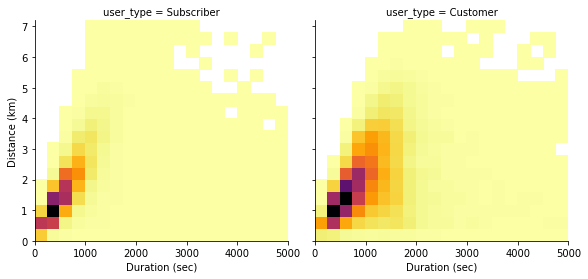

In [53]:
# create faceted heat maps on user_type
g = sb.FacetGrid(data = df_copy, col = 'user_type', col_wrap = 3, height = 4)

g.map(hist2dgrid, 'duration_sec', 'distance_km', color = 'inferno_r')
g.set_xlabels('Duration (sec)')
g.set_ylabels('Distance (km)')

plt.show()

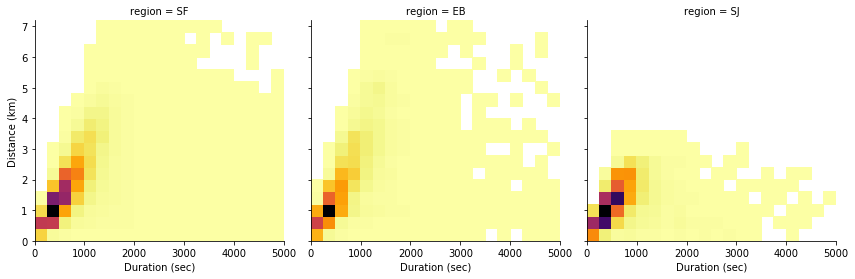

In [54]:
# create faceted heat maps on region
g = sb.FacetGrid(data = df_copy, col = 'region', col_wrap = 3, height = 4)

g.map(hist2dgrid, 'duration_sec', 'distance_km', color = 'inferno_r')
g.set_xlabels('Duration (sec)')
g.set_ylabels('Distance (km)')

plt.show()

For both the faceted heat maps above, we can observe the effect of the variables on the relationship between usage duration and distance. 

For the user type, customer tend to use GoBike for longer durations and distances, as compared to subscribers, which are mostly focused in shorter duration and distance. The more focused aspect in the subscriber part also indicates that subscribers are looking for a consistent experience (eg. daily commute), as compared to customer which uses GoBike for different purposes.

For the region, users in San Francisco uses GoBike for greater distances and duration as compared to users in East Bay and San Jose. The users in East Bay and San Jose are seen be very focused on short distance of 1 km and duration of 500 sec. This is interesting and we could use this insight to improve the service provided to the users in there. On another perspective, this also meant that there are less users in EB and SJ that has adopted GoBike as a daily mode of transport.

We will look into the traffic at the busiest bike station for each region. 

In [55]:
# calculate total number of entries recorded for a specific region
# SF
total_number = df_copy[df_copy.region == 'SF'].start_station_name.count()

# show the top 5 station with the most entries
# calcualte the proportion of entries from that specific station
(df_copy[df_copy.region == 'SF'].start_station_name.value_counts()/ total_number)[:5]

San Francisco Caltrain (Townsend St at 4th St)               0.029946
San Francisco Caltrain Station 2  (Townsend St at 4th St)    0.029178
San Francisco Ferry Building (Harry Bridges Plaza)           0.028247
Market St at 10th St                                         0.027364
Montgomery St BART Station (Market St at 2nd St)             0.025208
Name: start_station_name, dtype: float64

In [56]:
# SJ
total_number = df_copy[df_copy.region == 'SJ'].start_station_name.count()
(df_copy[df_copy.region == 'SJ'].start_station_name.value_counts()/ total_number)[:5]

San Jose Diridon Station          0.147513
Ryland Park                       0.064969
San Fernando St at 4th St         0.058673
Paseo De San Antonio at 2nd St    0.057912
San Fernando at 7th St            0.054176
Name: start_station_name, dtype: float64

In [57]:
# EB
total_number = df_copy[df_copy.region == 'EB'].start_station_name.count()
(df_copy[df_copy.region == 'EB'].start_station_name.value_counts()/ total_number)[:5]

MacArthur BART Station           0.112813
Bancroft Way at College Ave      0.086878
Broadway at 40th St              0.045566
Downtown Berkeley BART           0.040304
Bancroft Way at Telegraph Ave    0.039957
Name: start_station_name, dtype: float64

As expected, the top 3 stations from SJ and EB contributes up to 20% of the total GoBike traffic, as compared to SF which only contributes up to 10%.

We now look at the next variable age. Age is a discrete variable, to ease visualisation, we categorise them into 20s, 30s, 40s, 50s, 60s and 70s.

In [58]:
# Categorise age into categories
# we categorise age 18-19 into twenties for conveience sake
age_map = {1: 20, 2: 20, 3: 30, 4: 40, 5: 50, 6: 60, 7: 70}

# name variable as age_group
df_copy['age_group'] = (df_copy.member_age // 10).map(age_map)

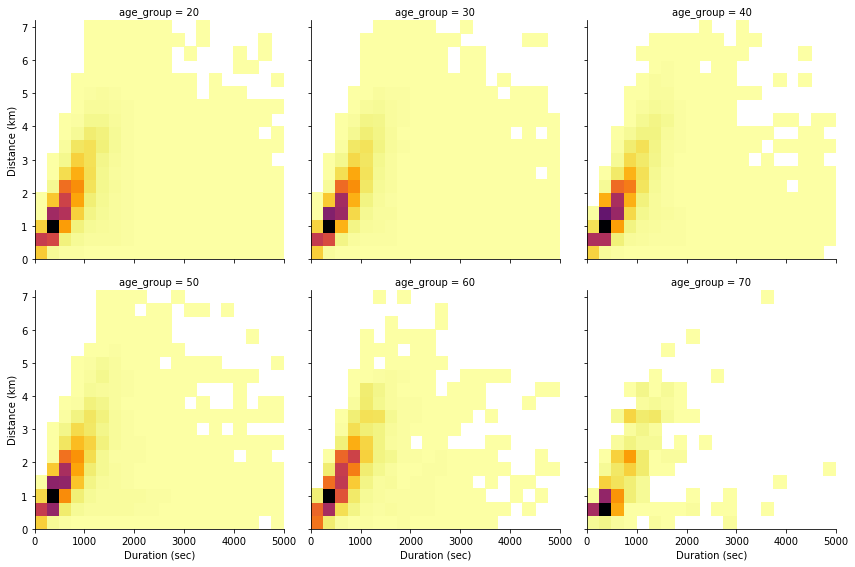

In [59]:
# create faceted heat maps on age_group
g = sb.FacetGrid(data = df_copy, col = 'age_group', col_wrap = 3, height = 4)

g.map(hist2dgrid, 'duration_sec', 'distance_km', color = 'inferno_r')
g.set_xlabels('Duration (sec)')
g.set_ylabels('Distance (km)')

plt.show()

There isn't much difference in terms of effect on the relationship between usage duraion and distance.

Instead, it is best to focus on the popular age range to see the differences. We will select the most popular age group of 25-45, and dive deeper.

In [60]:
# select dataset for member aged between 25 to 45
df_flag = ((df_copy['member_age'] >= 25) & (df_copy['member_age'] <= 45))
df_plot = df_copy.loc[df_flag,:]

/Users/yilepoh/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


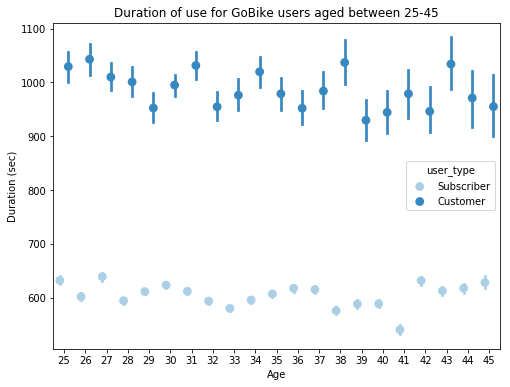

In [61]:
# setting the figure size
fig = plt.figure(figsize = [8,6])
# point plot of age against duration with user_type
ax = sb.pointplot(data = df_plot, x = 'member_age', y = 'duration_sec', hue = 'user_type',
                  palette = 'Blues', linestyles = '', dodge = 0.4)
plt.title('Duration of use for GoBike users aged between 25-45')
plt.ylabel('Duration (sec)')
plt.xlabel('Age')
ax.set_yticklabels([],minor = True)
plt.show();

/Users/yilepoh/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


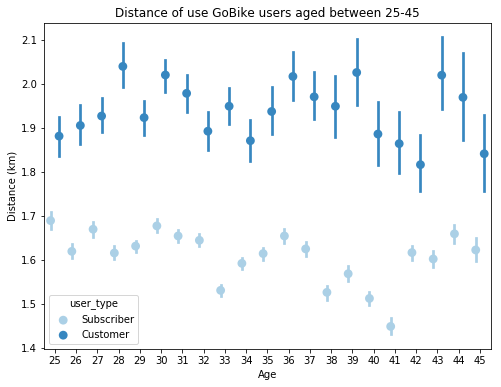

In [62]:
# reuse code above with different variable
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = df_plot, x = 'member_age', y = 'distance_km', hue = 'user_type',
           palette = 'Blues', linestyles = '', dodge = 0.4)
plt.title('Distance of use GoBike users aged between 25-45')
plt.ylabel('Distance (km)')
plt.xlabel('Age')
ax.set_yticklabels([],minor = True)
plt.show();

A point plot to illustrate differences between user behaviour of customer and subscriber over the selected age group.

We can see that age does not play a big factor in determining the usage duration of GoBike. Instead, there is a significant differnce in the usage duration between subscriber and customer. Subscriber generally uses GoBike for shorter distance and duration whereas customer uses GoBike for longer distance and duration.

/Users/yilepoh/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


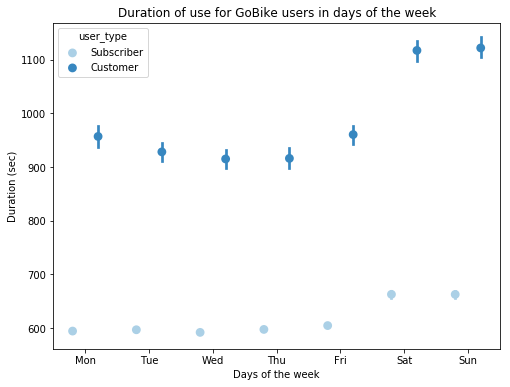

In [63]:
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = df_plot, x = 'week_day', y = 'duration_sec', hue = 'user_type',
                  palette = 'Blues', linestyles = '', dodge = 0.4)
plt.title('Duration of use for GoBike users in days of the week')
plt.ylabel('Duration (sec)')
plt.xlabel('Days of the week')
plt.xticks(ticks= np.arange(0, 7, 1), 
           labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_yticklabels([],minor = True)
plt.show();

/Users/yilepoh/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


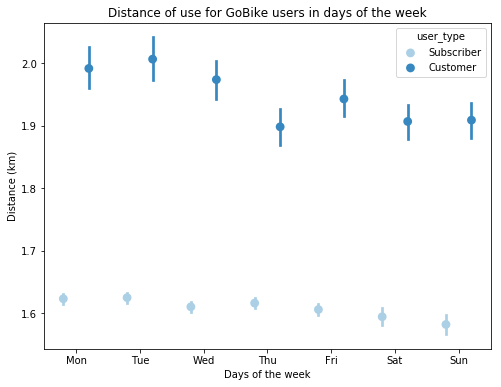

In [64]:
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = df_plot, x = 'week_day', y = 'distance_km', hue = 'user_type',
                  palette = 'Blues', linestyles = '', dodge = 0.4)
plt.title('Distance of use for GoBike users in days of the week')
plt.ylabel('Distance (km)')
plt.xlabel('Days of the week')
plt.xticks(ticks= np.arange(0, 7, 1), 
           labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_yticklabels([],minor = True)
plt.show();

Point plot to show different behaviours throughout the week for subscribers and customers.

Interesting observation that the duration of GoBike usage increases over the weekend for both subscriber and customer. This indicates that users generally uses GoBike for non-commute transportation purposes.

The distance of GoBike usage decreases slightly over the weekend for both subscribers and customers.

/Users/yilepoh/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


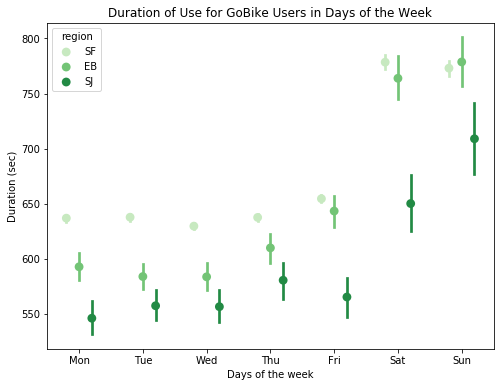

In [68]:
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = df_copy, x = 'week_day', y = 'duration_sec', hue = 'region',
                  palette = 'Greens', linestyles = '', dodge = 0.4)
plt.title('Duration of Use for GoBike Users in Days of the Week')
plt.ylabel('Duration (sec)')
plt.xlabel('Days of the week')
plt.xticks(ticks= np.arange(0, 7, 1), 
           labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_yticklabels([],minor = True)
plt.show();

We see that GoBike usage durations is significantly higher in the weekends. This is true across all regions in the Bay Area, namely San Francisco, East Bay and San Jose. The spike in usage duration over the weekend is consistent with the findings above.

Looking at the user behavior for each region, we find that users in San Francisco has the highest GoBike usage durations, followed by users in East Bay and San Jose. This indicates GoBike has better user adapotion in San Francisco. This is reasonable as San Francisco has the most GoBike facilities (bike docking stations), as compared to San Jose which has relatively the least facilities.

### Relationships observed in this part of the investigation. 
We extended our investigation in terms of customer demographics and time on the relationship between usage duration and distance.

The multivariate exploration showed that the user type does have a significant impact on the duration and distance. This observaion is observed in both the heatmap as well as the pointplot.

We find that member age does not play a big part in the user behaviour, as the differences is not obvious in the heatmaps as well as in the pointplots.

The user region has an effect on the duration of use. The regions where GoBike has greater coverage tends to have greater duration of use.

### Interesting interactions between features,
Despite having lower traffic in the weekends, users tend to rent GoBike for a longer period of time. Interestingly, the distance travelled by the users in the weekend is shorter as compared to the distances travelled inthe weekdays. 